In [1]:
from scipy.optimize import curve_fit
import hyperspy.api as hys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import tkinter.filedialog as tkf

In [2]:
ll_adr = tkf.askopenfilename()
print(ll_adr)
hl_adr = tkf.askopenfilename()
print(hl_adr)

D:/repository/data_repository/EELS/20200721_amorphous_C_TZ/20200724_processed/B_EELS Spectrum Image (low-loss) (aligned).dm3
D:/repository/data_repository/EELS/20200721_amorphous_C_TZ/20200724_processed/B_Deconvolved SI.dm3


In [3]:
ll = hys.load(ll_adr, signal_type="EELS")
print(ll)
hl = hys.load(hl_adr, signal_type="EELS")
print(hl)

<EELSSpectrum, title: B_EELS Spectrum Image (low-loss) (aligned), dimensions: (29, 11|2022)>
<EELSSpectrum, title: B_Deconvolved SI, dimensions: (29, 11|2022)>


In [4]:
ll.align_zero_loss_peak(also_align=[hl], signal_range=(-10., 10.))
print(ll)
print(hl)


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	0.00945
std:	0.0501

min:	-0.162
Q1:	-0.0242
median:	0.0133
Q3:	0.0383
max:	0.163



<EELSSpectrum, title: B_EELS Spectrum Image (low-loss) (aligned), dimensions: (29, 11|1995)>
<EELSSpectrum, title: B_Deconvolved SI, dimensions: (29, 11|1995)>


In [5]:
step = hl.axes_manager[2].scale
print(step)
offset = hl.axes_manager[2].offset
print(offset)
e_size = hl.axes_manager[2].size
print(e_size)

0.02500000037252903
271.05642617517685
1995


In [6]:
e_range = np.linspace(offset, offset+e_size*step, e_size)
print(e_range.shape)
print(e_range)

(1995,)
[271.05642618 271.08143871 271.10645125 ... 320.88140184 320.90641438
 320.93142692]


In [7]:
# select an interesting area
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.sum(hl.data, axis=(2)), cmap="gray")

def onselect(eclick, erelease):
    print('startposition: (%f, %f)' % (eclick.xdata, eclick.ydata))
    print('endposition  : (%f, %f)' % (erelease.xdata, erelease.ydata))

box = RectangleSelector(ax, onselect)
plt.show()

startposition: (-0.125806, 2.811155)
endposition  : (28.238065, 9.135026)


In [8]:
signal = np.sum(hl.data[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])], axis=(0, 1))
print(signal.shape)
print(signal)

(1995,)
[  -18.62735505   641.84938845   834.3707868  ...  9663.10699953
 10224.20484204 10782.25758126]


In [9]:
signal = hys.signals.Signal1D(signal)
signal.set_signal_type("EELS")
signal.axes_manager[0].name = "Energy loss"
signal.axes_manager[0].offset = offset
signal.axes_manager[0].scale = step
signal.axes_manager[0].size = e_size
print(signal)

<EELSSpectrum, title: , dimensions: (|1995)>


In [ ]:
%matplotlib qt
signal.plot()

In [10]:
pi_center = 287.0
pi_half_wsize = 2.0
sigma_center = 295.0
sigma_half_wsize = 4.0

In [14]:
print(pi_center-pi_half_wsize , pi_center+pi_half_wsize )
pi_range = e_range[np.where(e_range > pi_center-pi_half_wsize)]
pi_range = pi_range[np.where(pi_range < pi_center+pi_half_wsize)]
print(pi_range.shape)
print(pi_range[0], pi_range[-1])
pi_signal_range = signal.isig[pi_range[0]:pi_range[-1]+step].data
print(pi_signal_range.shape)

285.0 289.0
(160,)
285.0134223711162 288.99041591081937
(160,)


In [15]:
print(sigma_center-sigma_half_wsize, sigma_center+sigma_half_wsize)
sigma_range = e_range[np.where(e_range > sigma_center-sigma_half_wsize)]
sigma_range = sigma_range[np.where(sigma_range < sigma_center+sigma_half_wsize)]
print(sigma_range.shape)
print(sigma_range[0], sigma_range[-1])
sigma_signal_range = signal.isig[sigma_range[0]:sigma_range[-1]].data
print(sigma_signal_range.shape)

291.0 299.0
(320,)
291.01643148764924 298.99543110504106
(320,)


In [16]:
%matplotlib inline

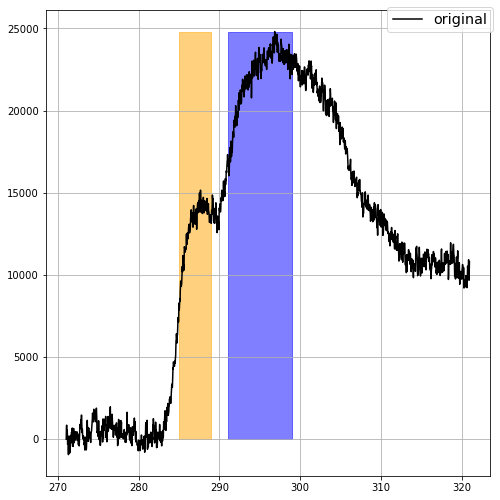

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(e_range, signal.data, 'k-', label="original")
ax.fill_between([pi_range[0], pi_range[-1]], np.max(signal.data), 
                alpha=0.5, color="orange")
ax.fill_between([sigma_range[0], sigma_range[-1]], np.max(signal.data), 
                alpha=0.5, color="blue")
ax.grid()
fig.legend(fontsize="x-large")
fig.tight_layout()
plt.show()

In [18]:
Epi = np.trapz(pi_signal_range, pi_range)
Esigma = np.trapz(sigma_signal_range, sigma_range)
print(Epi, Esigma)

51254.55285877563 175920.22869696614


In [19]:
sp2_ratio = Epi / (Epi+Esigma)
print(sp2_ratio * 100)

22.561726485560335


In [ ]:
def gauss_p1(x, a, sigma):
    return a*np.exp(-(x-286.5)**2/(2*sigma**2))

def gauss_p2(x, a, sigma):
    return a*np.exp(-(x-289.0)**2/(2*sigma**2))

def gauss_p3(x, a, sigma):
    return a*np.exp(-(x-293.5)**2/(2*sigma**2))

In [ ]:
def lorentz_p1(x, gamma):
    return gamma / (2 * np.pi * ((x-286.5)**2 + (gamma/2)**2))

def lorentz_p2(x, a, gamma):
    return gamma / (2 * np.pi * ((x-289.0)**2 + (gamma/2)**2))

def lorentz_p3(x, a, gamma):
    return gamma / (2 * np.pi * ((x-293.5)**2 + (gamma/2)**2))

In [ ]:
%matplotlib qt
roi1 = hys.roi.SpanROI(left=275.0, right=280.0)
signal.plot()
roi1.add_widget(signal, axes=["Energy loss"])

In [ ]:
print(roi1.left, roi1.right)
p1_range = e_range[np.where(e_range > roi1.left)]
p1_range = p1_range[np.where(p1_range < roi1.right)]
print(p1_range.shape)
print(p1_range[0], p1_range[-1])
p1_signal_range = signal.isig[p1_range[0]:p1_range[-1]+step].data
print(p1_signal_range.shape)

In [ ]:
%matplotlib qt
roi2 = hys.roi.SpanROI(left=275.0, right=280.0)
signal.plot()
roi2.add_widget(signal, axes=["Energy loss"])

In [ ]:
print(roi2.left, roi2.right)
p2_range = e_range[np.where(e_range >= roi2.left)]
p2_range = p2_range[np.where(p2_range < roi2.right)]
print(p2_range.shape)
print(p2_range[0], p2_range[-1])
p2_signal_range = signal.isig[p2_range[0]:p2_range[-1]+step].data
print(p2_signal_range.shape)

In [ ]:
%matplotlib qt
roi3 = hys.roi.SpanROI(left=275.0, right=280.0)
signal.plot()
roi3.add_widget(hl, axes=["Energy loss"])

In [ ]:
print(roi3.left, roi3.right)
p3_range = e_range[np.where(e_range >= roi3.left)]
p3_range = p3_range[np.where(p3_range < roi3.right)]
print(p3_range.shape)
print(p3_range[0], p3_range[-1])
p3_signal_range = signal.isig[p3_range[0]:p3_range[-1]+step].data
print(p3_signal_range.shape)

In [ ]:
popt_p1, pcov_p1 = curve_fit(gauss_p1, p1_range, p1_signal_range)
print(popt_p1)
popt_p2, pcov_p2 = curve_fit(gauss_p2, p2_range, p2_signal_range)
print(popt_p2)
popt_p3, pcov_p3 = curve_fit(gauss_p3, p3_range, p3_signal_range)
print(popt_p3)

In [ ]:
p1 = gauss_p1(e_range, *popt_p1)
p2 = gauss_p2(e_range, *popt_p2)
p3 = gauss_p3(e_range, *popt_p3)

In [ ]:
popt_p1l, pcov_p1l = curve_fit(lorentz_p1, p1_range, p1_signal_range)
print(popt_p1l)
popt_p2l, pcov_p2l = curve_fit(lorentz_p2, p2_range, p2_signal_range)
print(popt_p2l)
popt_p3l, pcov_p3l = curve_fit(lorentz_p3, p3_range, p3_signal_range)
print(popt_p3l)

In [ ]:
p1l = lorentz_p1(e_range, *popt_p1l)
p2l = lorentz_p2(e_range, *popt_p2l)
p3l = lorentz_p3(e_range, *popt_p3l)

In [ ]:
%matplotlib inline

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(e_range, signal, 'k-', label="original")
ax.plot(e_range, p1, 'r-', label="gaussian")
ax.plot(e_range, p2, 'g-', label="gaussian")
ax.plot(e_range, p3, 'b-', label="gaussian")
ax.grid()
fig.legend(fontsize="x-large")
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(e_range, signal, 'k-', label="original")
ax.plot(e_range, p1l, 'r-', label="lorentzian")
ax.plot(e_range, p2l, 'g-', label="lorentzian")
ax.plot(e_range, p3l, 'b-', label="lorentzian")
ax.grid()
fig.legend(fontsize="x-large")
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(e_range, signal, 'k-', label="original")
ax.plot(e_range, p1, 'r-', label="gaussian")
ax.plot(e_range, p2l, 'g-', label="lorentzian")
ax.plot(e_range, p3, 'b-', label="gaussian")
ax.grid()
fig.legend(fontsize="x-large")
fig.tight_layout()
plt.show()

In [ ]:
p1_area = np.trapz(p1, e_range)
p2_area = np.trapz(p2l, e_range)
p3_area = np.trapz(p3, e_range)
print(p1_area, p2_area, p3_area)

In [ ]:
sp2_ratio = (p1_area + p2_area) / (p1_area + p2_area + p3_area)
print(sp2_ratio * 100)

### temp

In [ ]:
def multi_gauss(x, a1, a2, a3, s1, s2, s3):
    return a1*np.exp(-(x-286.5)**2/(2*s1**2)) + a2*np.exp(-(x-286.5)**2/(2*s2**2)) + a3*np.exp(-(x-293.5)**2/(2*s3**2))

In [ ]:
m_range = e_range[np.where(e_range >= roi.left)]
m_range = m_range[np.where(m_range < roi.right)]
print(m_range.shape)
print(m_range[0], m_range[-1])
m_signal_range = hl.isig[m_range[0]:m_range[-1]].data
print(m_signal_range.shape)

In [ ]:
popt_m, pcov_m = curve_fit(multi_gauss, m_range, m_signal_range, maxfev=2000)
print(popt_m)

In [ ]:
mg = multi_gauss(e_range, *popt_m)

In [ ]:
p1 = gauss_p1(e_range, popt_m[0], popt_m[3])
p2 = gauss_p2(e_range, popt_m[1], popt_m[4])
p3 = gauss_p3(e_range, popt_m[2], popt_m[5])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(e_range, signal, 'k-')
ax.plot(e_range, mg, 'r-')
ax.plot(e_range, p1, 'r-')
ax.plot(e_range, p2, 'g-')
ax.plot(e_range, p3, 'b-')
ax.grid()
fig.tight_layout()
plt.show()